## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle as pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score)
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import BaggingClassifier

### Load the dataset

In [2]:
airline_data = pd.read_csv('Invistico_Airline.csv', on_bad_lines="skip")

### Display the data

In [3]:
airline_data.head(10)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,...,2,2,5,4,5,5,4,2,0,0.0
6,satisfied,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,...,5,5,5,0,5,5,5,3,17,15.0
7,satisfied,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,3,...,2,2,3,3,4,5,4,2,0,0.0
8,satisfied,Loyal Customer,56,Personal Travel,Business,73,0,0,0,3,...,5,4,4,0,1,5,4,4,0,0.0
9,satisfied,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,3,...,2,2,2,4,5,3,4,2,30,26.0


### Display the data type for each column

In [4]:
airline_data.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
dtype: obj

## Model Preparation

In [5]:
# Convert the object predictor variables to numerical dummies.
airline_data_dummies = pd.get_dummies(airline_data, columns=["Customer Type", "Type of Travel", "Class", "satisfaction"])
airline_data_dummies.dtypes

Age                                    int64
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
Customer Type_Loyal Customer            bool
Customer Type_disloyal Customer         bool
Type of Travel_Business travel          bool
Type of Travel_Personal Travel          bool
Class_Busi

### Isolate target and predictor variables

In [6]:
# Define the target variable.
y = airline_data_dummies["satisfaction_satisfied"]

# Define the predictor variables.
X = airline_data_dummies.drop(columns=["satisfaction_satisfied", "satisfaction_dissatisfied"])

### Split into training and testing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model Building

#### Create xgb model

In [8]:
# Define xgb to be your XGBClassifier.
### YOUR CODE HERE ###
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42, objective="binary:logistic")

### Define the parameters for hyperparameter tuning

In [9]:
cv_params = {
    "max_depth" : [9, 15],
    "min_child_weight" : [3, 10, 30],
    "learning_rate" : [0.1, .001, .01],
    "n_estimators" : [100, 200, 400],
    "subsample" : [0.75, 1.0],
    "colsample_bytree" : [0.75, 1.0]
}

### Define how the models will be evaluated

In [10]:
scoring_vals = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

### Construct GridSearch cross-validation 

In [11]:
grid_search_model = GridSearchCV(
    estimator=xgb_model,
    param_grid=cv_params,
    scoring=scoring_vals,
    cv=5,
    refit='f1',
    n_jobs=-1,
    verbose=1
)

### Fit the GridSearch model to the training data

In [12]:
%%time
grid_search_model.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
CPU times: user 6.04 s, sys: 6.13 s, total: 12.2 s
Wall time: 6min 10s


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.75, 1.0], 'learning_rate': [0.1, 0.001, ...], 'max_depth': [9, 15], 'min_child_weight': [3, 10, ...], ...}"
,scoring,"{'accuracy': 'accuracy', 'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}"
,n_jobs,-1
,refit,'f1'
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [19]:
grid_search_model.best_params_

{'colsample_bytree': 0.75,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 3,
 'n_estimators': 200,
 'subsample': 1.0}

### Save model using `pickle`

In [14]:
with open("xgb_gridsearch_model.pkl", "wb") as f:
    pickle.dump(grid_search_model, f) 

## Results and Evaluation

In [15]:
# Predict on test data
y_pred = grid_search_model.predict(X_test)

### Print evaluation metrics

In [16]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"Precision socre: {precision_score(y_test, y_pred)}")
print(f"Recall score: {recall_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred)}")

Accuracy score: 0.9596242685555898
Precision socre: 0.9720495122925105
Recall score: 0.9540365020714365
F1 score: 0.9629587771593253


### Plot confusion matrix

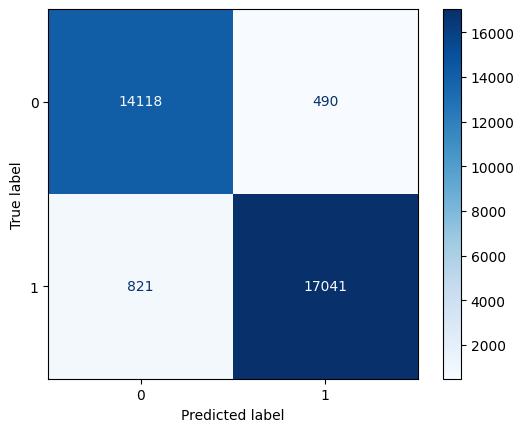

In [17]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search_model.best_estimator_.classes_)
disp.plot(cmap="Blues")

### Plot featue importance

<Figure size 1000x600 with 0 Axes>

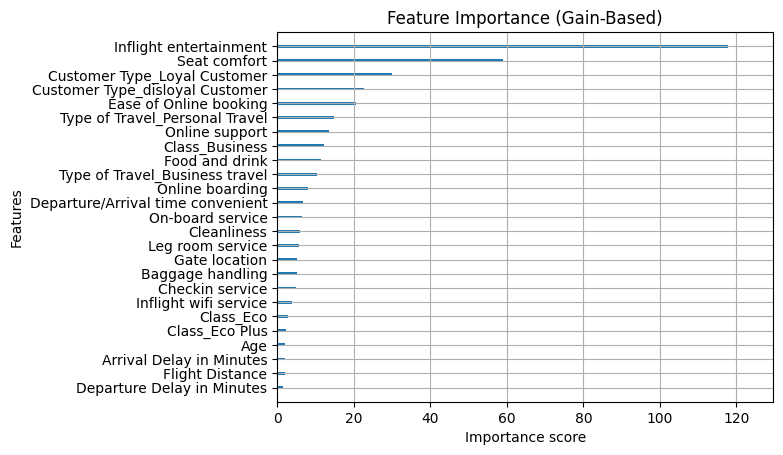

In [18]:
# Plot the relative feature importance of the predictor variables in the model.
plt.figure(figsize=(10, 6))
plot_importance(grid_search_model.best_estimator_, importance_type='gain', show_values=False)
plt.title('Feature Importance (Gain-Based)')
plt.grid(True)
plt.show()